<a href="https://colab.research.google.com/github/Zouzzou21/TIP-Projet-IRM-Cerveau/blob/main/TUMOR_DETECTION-VF-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import jeux de donnée

## Import des images d'entrainement/test et decompression du fichier zip.

In [1]:
#TELECHARGEMENT DU FICHIER ZIP QUI CONTIENT NOS DONNEES D'APPRENTISSAGES
#TELECHARGEMENT DU FICHIER ZIP QUI CONTIENT NOS DONNEES DE TESTS
#SOURCE KAGGLE :
#https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
#https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
#https://www.kaggle.com/datasets/denizkavi1/brain-tumor
#https://www.kaggle.com/datasets/thomasdubail/brain-tumors-256x256

!rm -rf FINAL* && rm -rf TEST*
!wget -qq https://github.com/Zouzzou21/TIP-Projet-IRM-Cerveau/raw/main/FINAL4DB.zip && wget -qq https://github.com/Zouzzou21/TIP-Projet-IRM-Cerveau/raw/main/TEST4DB.zip
!unzip -qq FINAL4DB.zip && unzip -qq TEST4DB.zip
!mv FINAL4DB FINAL && mv TEST4DB TEST
!rm -rf FINAL4DB.zip && rm -rf TEST4DB.zip

# Python

## Import python

In [2]:
#IMPORT DE TOUTES LES LIBRAIRIES NECESSAIRES
import io, os, sys, keras, pathlib, cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image

## Hide print

In [3]:
#FONCTION QUI PERMET DE CACHER LES TRAITEMENTS/AFFICHAGES
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Recupération du jeux de données

In [4]:
data_dir_FINAL = pathlib.Path('/content/FINAL')
image_count_FINAL = len(list(data_dir_FINAL.glob('*/*')))
# print(data_dir)
# print(os.path.abspath(data_dir))
print("Nombre d'images dans le dataset :", image_count_FINAL)

data_dir_TEST = pathlib.Path('/content/TEST')
image_count_TEST = len(list(data_dir_TEST.glob('*/*')))
print("Nombre d'images dans le jeu de test :", image_count_TEST)

Nombre d'images dans le dataset : 4704
Nombre d'images dans le jeu de test : 3161


## Mise en forme des images (size et colorimetrie)

In [5]:
#MISE EN PLACE DES REPARTITIONS DES IMAGES POUR LE RESEAU DE NEURONE ET CONFIGURATION DE CE-DERNIER
batch_size = 3
img_width = img_height = 500

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_FINAL,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_FINAL,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

liste_classe = val_data.class_names
print("Nom des classes : ", liste_classe)

Found 4704 files belonging to 4 classes.
Using 3764 files for training.
Found 4704 files belonging to 4 classes.
Using 940 files for validation.
Nom des classes :  ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


## Filtrage

### Kernel pour filtrer les images pour les contours

Ce code permet de filtrer les contours des images d'IRM

**⚠️ CONSOME TROP DE RAM DONC N'EST PAS IMPLEMENTABLE ⚠️**

In [6]:
# # Maintenant, image_arrays contient des tableaux de valeurs de pixels pour toutes les images du dossier
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# height = width = 512

# def image_to_array(image_path):
#     # Ouvre l'image et la convertit en tableau de valeurs de pixels
#     img = Image.open(image_path).convert('L')  # 'L' pour convertir en niveaux de gris
#     img_array = np.array(img)
#     return img_array

# def process_folder(folder_path):
#     image_arrays = []  # Tableau pour stocker les tableaux d'images
#     # Parcourt récursivement les fichiers du dossier
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
#                 # Vérifie si le fichier est une image (vous pouvez ajouter d'autres extensions si nécessaire)
#                 file_path = os.path.join(root, file)
#                 img_array = image_to_array(file_path)
#                 image_arrays.append(cv2.resize(img_array , dsize=(height,width), interpolation=cv2.INTER_CUBIC))
#     return image_arrays

# # Exemple d'utilisation
# folder_path = 'FINAL'
# image_arrays = process_folder(folder_path)

# image_arrays_bw = []
# for img in image_arrays:
#   #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#   #plt.axis('off')
#   img_bw = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
#   (thresh, img_bw) = cv2.threshold(img_bw, 50, 255, cv2.THRESH_BINARY)
#   image_arrays_bw.append(img_bw)

# image_arrays_bw_filtred = []
# for img in image_arrays_bw:
#   #plt.axis('off')
#   #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#   #plt.show()
#   kernelV = np.matrix([[-10,0,10],[-10,0,10],[-10,0,10]])
#   kernelH = np.matrix([[10,10,10],[0,0,0],[-10,-10,-10]])
#   #print("Kernel vertical: ", kernelV)
#   #print("Kernel horizontal", kernelH)
#   img_kv = cv2.filter2D(img, -1, kernelV)
#   img_kvh = cv2.filter2D(img_kv, -1, kernelH)
#   image_arrays_bw_filtred.append(img_kvh)

# plt.figure(figsize=(32, 32))
# for i in range(3):
#   ax = plt.subplot(1, 3, i + 1)
#   plt.imshow(cv2.cvtColor(image_arrays_bw_filtred[i], cv2.COLOR_BGR2RGB))
#   plt.axis("off")

# plt.figure(figsize=(32, 32))
# for i in range(3):
#   ax = plt.subplot(1, 3, i + 1)
#   plt.imshow(cv2.cvtColor(image_arrays[i], cv2.COLOR_BGR2RGB))
#   plt.axis("off")

# plt.figure(figsize=(32, 32))
# for i in range(3):
#   ax = plt.subplot(1, 3, i + 1)
#   plt.imshow(cv2.cvtColor(image_arrays_bw[i], cv2.COLOR_BGR2RGB))
#   plt.axis("off")

### Filtrage GLCM

In [7]:
print("WIP")

WIP


## Affichage des differentes photos de tumeurs

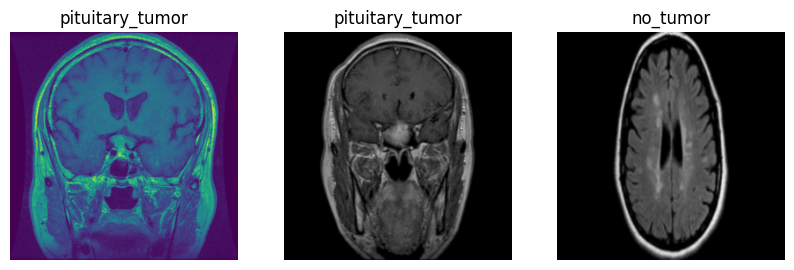

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(val_data.class_names[labels[i]])
    plt.axis("off")

## Création du réseau de neuronnes

⚠️ Peux prendre du temps, soyez patient ⚠️

In [9]:
#NOMBRE DE CLASSE 4, CELA CORRESPOND A NOS 3 TUMEURS DIFFERENTES ET L'ABSENCE DE TUMEUR
num_classes = 4

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    #NORMALISER LES COULEURS POUR FAIRE QUE LES PIXELS SOIT COMPRIS ENTRE 0 ET 1
    #PERMET LA CONVERGENCE PLUS RAPIDE LORS DE L'APPRENTISSAGE DU MODELE
    layers.experimental.preprocessing.Rescaling(1./255),
    #COUCHE CONVOLUTIVE DE 128 NEURONES AVEC RELU
    #LA VALEUR 4 CORRESPOND AU FILTRE QUI SE BALADE SUR L'IMAGE DE FORMAT 4*4
    #RELU PERMET D'EVITER LA NON-LINEARITE EN PASSANT LES IMAGES NEGATIVES A 0
    layers.Conv2D(128, 2, activation='relu'),
    #DROPOUT PERMET D'EVITER LE SURAPPRENSTISSAGE
    layers.Dropout(0.05, noise_shape=None, seed=None),
    layers.MaxPooling2D(),
    #COUCHE CONVOLUTIVE DE 64 NEURONES AVEC RELU
    layers.Conv2D(64, 4, activation='relu'),
    layers.Dropout(0.05, noise_shape=None, seed=None),
    layers.MaxPooling2D(),
    #COUCHE CONVOLUTIVE DE 32 NEURONES AVEC RELU
    layers.Conv2D(32, 8, activation='relu'),
    layers.Dropout(0.05, noise_shape=None, seed=None),
    layers.MaxPooling2D(),
    #COUCHE CONVOLUTIVE DE 16  NEURONES AVEC RELU
    layers.Conv2D(16, 2, activation='relu'),
    #CREATION D'UNE COUCHE DE POOLING :
    #REDUIT LES DIMENSIONS SPATIALES DE LA REPRESENTATION DE L'IMAGE EN SELECTIONNANT VMAX D'UNE REGION DONNEE
    layers.MaxPooling2D(),
    #CONVERTIR LES DONNEES D'ENTREE BIDIMENSIONNELLES EN UN VECTEUR UNIDIMENSIONNEL
    layers.Flatten(),
    #COUCHE CONVOLUTIVE DE 64 NEURONES AVEC RELU
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.05, noise_shape=None, seed=None),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.05, noise_shape=None, seed=None),
    #SOFTMAX FONCTION D'ACTIVATION DE DERNIERE COUCHE POUR MULTI-CLASSES
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

logdir = "logs"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, write_images=True)
#AVEC 3 EPOCHS VAL_ACCURACY 74% AVEC UN DROPOUT A 0.05
#AVEC 10 EPOCHS VAL_ACCURACY 77% AVEC UN DROPOUT A 0.05
#AVEC 10 EPOCHS VAL_ACCURACY  56% AVEC UN DROPOUT A 0.5
#AVEC 10 EPOCHS VAL_ACCURACY 73% AVEC UN DROPOUT A 0.03
entrainement_reseau = 100

model.fit(
    train_data,
    validation_data=val_data,
    epochs=entrainement_reseau,
    callbacks=[early_stopping]
)

Epoch 1/100
1255/1255 [==============================] - 215s 161ms/step - loss: 1.1620 - accuracy: 0.4280 - val_loss: 1.0273 - val_accuracy: 0.4830
Epoch 2/100
1255/1255 [==============================] - 199s 159ms/step - loss: 0.9936 - accuracy: 0.5186 - val_loss: 0.8632 - val_accuracy: 0.5915
Epoch 3/100
1255/1255 [==============================] - 198s 157ms/step - loss: 0.7297 - accuracy: 0.7006 - val_loss: 0.6848 - val_accuracy: 0.7223
Epoch 4/100
1255/1255 [==============================] - 198s 158ms/step - loss: 0.4766 - accuracy: 0.8146 - val_loss: 0.6280 - val_accuracy: 0.7649
Epoch 5/100
1255/1255 [==============================] - 197s 156ms/step - loss: 0.2850 - accuracy: 0.8889 - val_loss: 0.6136 - val_accuracy: 0.7755
Epoch 6/100
1255/1255 [==============================] - 196s 156ms/step - loss: 0.2163 - accuracy: 0.9192 - val_loss: 0.7058 - val_accuracy: 0.7787
Epoch 7/100
1255/1255 [==============================] - 196s 156ms/step - loss: 0.1459 - accuracy: 0.9458

## Affichage du sommaire du model de neuronnes

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 499, 499, 128)     1664      
                                                                 
 dropout (Dropout)           (None, 499, 499, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 246, 64)      131136    
                                                                 
 dropout_1 (Dropout)         (None, 246, 246, 64)      0         
                                                        

## Chargement des images de test

In [11]:
#REPERTOIRE DES CLASSES
no_tumor_dir = os.path.join('/content/TEST/no_tumor')
glioma_tumor_dir = os.path.join('/content/TEST/glioma_tumor/')
meningioma_tumor_dir = os.path.join('/content/TEST/meningioma_tumor')
pituitary_tumor_dir = os.path.join('/content/TEST/pituitary_tumor')

#OBTENIR LE NOMBRE D'IRM EN FONCTION DE CHAQUE CLASSE/REPERTOIRE
nbrPasTumeur = len(os.listdir(no_tumor_dir))
nbrGliomaTumeur = len(os.listdir(glioma_tumor_dir))
nbrMeningiomaTumeur = len(os.listdir(meningioma_tumor_dir))
nbrPituitaryTumeur = len(os.listdir(pituitary_tumor_dir))

## Test du model avec les images de test

In [12]:
#MISE EN PLACE DES COMPTEURS POUR DETERMINER LES DETECTIONS/ERREURS PAR RAPPORT AU RESEAU
CompteurGlioma = CompteurPasTumeur = CompteurMeningioma = CompteurPituitary = 0
CompteurLogique = nbrErreurEch = nbrErreurClasse = iteration = percentErreur = 0
liste_Erreur_Par_Classe = []
liste_Erreur_10ech = []

#POUR CHAQUE IRM, ON L'ENVOIE DANS LE RESEAU DE NEURONE POUR DETERMINER SA CLASSE
for dossier_parent, sous_repertoires, fichiers in os.walk(data_dir_TEST):
    with HiddenPrints():
      for nom_fichier in fichiers:
          CompteurLogique = CompteurLogique + 1
          iteration = iteration + 1
          chemin_image = os.path.join(dossier_parent, nom_fichier)

          if nom_fichier.lower().endswith(('.png', '.jpg', '.jpeg')):
            #TRAITEMENT DES IMAGES POUR L'ENVOYER DANS LE RESEAU AFIN DE DETERMINER LA CLASSE DE L'IMAGE
            image_to_predict_RGB = Image.open(chemin_image).convert('RGB')
            image_to_predict_GRAY = cv2.cvtColor(np.array(image_to_predict_RGB), cv2.COLOR_RGB2GRAY)
            image_to_predict = np.array(image_to_predict_RGB)
            image_to_predict = cv2.resize(image_to_predict, (img_height, img_width))
            image_to_predict = np.expand_dims(image_to_predict, axis=0)
            ClassProbability = model.predict(image_to_predict)

            #DETERMINER LA PROBABILITE LA PLUS FORTE
            numpy_array = np.array(ClassProbability)

            #OBTENIR L'INDEX OU LA PROBABILITE EST LA PLUS FORTE
            val = np.argmax(numpy_array)

          #EN FONCTION DE LA VALEUR MAX DE PROBABILITE DANS CLASSPROBABILITY ON ESTIME SA CLASSE
          #LA FIABILITE N'EST PAS DE 100%, C'EST POUR CELA QU'ON PARLE D'ESTIMATION
          if val == 0:
            CompteurGlioma = CompteurGlioma + 1
          elif val == 1 :
            CompteurMeningioma = CompteurMeningioma + 1
          elif val == 2  :
            CompteurPasTumeur = CompteurPasTumeur + 1
          elif val == 3 :
            CompteurPituitary = CompteurPituitary + 1

          #COMPTEUR DU NOMBRE D'ERREUR TOUS LES 10 ECHANTILLONS ET COMPTEUR PAR CLASSE
          if dossier_parent == "/content/TEST/glioma_tumor":
            if CompteurLogique != CompteurGlioma :
              CompteurGlioma = CompteurGlioma + 1
              nbrErreurEch = nbrErreurEch + 1
              nbrErreurClasse = nbrErreurClasse + 1

          elif dossier_parent == "/content/TEST/no_tumor":
            if CompteurLogique != CompteurPasTumeur :
              CompteurPasTumeur = CompteurPasTumeur + 1
              nbrErreurEch = nbrErreurEch + 1
              nbrErreurClasse = nbrErreurClasse + 1

          elif dossier_parent == "/content/TEST/pituitary_tumor":
            if CompteurLogique != CompteurPituitary :
              CompteurPituitary = CompteurPituitary + 1
              nbrErreurEch = nbrErreurEch + 1
              nbrErreurClasse = nbrErreurClasse + 1

          elif dossier_parent == "/content/TEST/meningioma_tumor":
            if CompteurLogique != CompteurMeningioma :
              CompteurMeningioma = CompteurMeningioma + 1
              nbrErreurEch = nbrErreurEch + 1
              nbrErreurClasse = nbrErreurClasse + 1

          if iteration % 10 == 0:
            #AJOUT DES ERREURS TOUS LES 10 ECHANTILLONS DANS LA LISTE
            liste_Erreur_10ech.append(nbrErreurEch)
            nbrErreurEch = 0

      #AJOUT DU NOMBRE D'ERREUR PAR CLASSE
      liste_Erreur_Par_Classe.append(nbrErreurClasse)
      CompteurLogique = CompteurGlioma = CompteurMeningioma = CompteurPasTumeur = CompteurPituitary = nbrErreurClasse = 0

Debug

In [13]:
print("List of errors every 10 samples:",liste_Erreur_10ech)
#ORDRE DES CLASSES ETUDIEES : GLIOMA / NO_TUMOR / MENIGIOMA_TUMOR / PITUITAR_TUMOR
#SUPRESSION DU PREMIER ELEMENT SINON FORMAT 5 VALEURS
if len(liste_Erreur_Par_Classe) == 5:
  del(liste_Erreur_Par_Classe[0])
print("Number of errors by tumor classes:",liste_Erreur_Par_Classe)

List of errors every 10 samples: [4, 4, 4, 1, 2, 2, 2, 4, 4, 3, 1, 2, 2, 4, 4, 4, 2, 4, 4, 4, 6, 4, 3, 3, 2, 4, 4, 2, 3, 5, 4, 3, 2, 5, 3, 1, 3, 2, 5, 5, 3, 3, 3, 3, 3, 2, 3, 2, 5, 4, 0, 5, 3, 4, 3, 3, 3, 2, 6, 3, 3, 2, 3, 5, 4, 2, 3, 6, 3, 2, 2, 7, 1, 3, 4, 2, 5, 3, 1, 2, 1, 3, 3, 2, 0, 4, 0, 3, 3, 2, 2, 2, 2, 2, 1, 2, 4, 4, 3, 4, 3, 2, 2, 4, 3, 3, 2, 4, 3, 3, 3, 2, 3, 2, 3, 4, 3, 3, 3, 1, 2, 1, 1, 3, 7, 3, 2, 1, 0, 5, 3, 2, 1, 3, 2, 8, 4, 6, 7, 8, 7, 5, 6, 5, 3, 6, 4, 8, 5, 6, 7, 4, 8, 6, 6, 8, 5, 3, 4, 5, 4, 7, 2, 4, 4, 5, 7, 5, 5, 8, 3, 5, 5, 5, 5, 7, 6, 6, 5, 5, 4, 7, 6, 6, 3, 5, 4, 6, 8, 5, 4, 2, 5, 7, 4, 7, 9, 6, 6, 6, 7, 4, 8, 5, 3, 6, 5, 7, 5, 4, 8, 5, 6, 7, 4, 6, 6, 5, 4, 3, 7, 5, 7, 6, 6, 5, 5, 4, 3, 6, 6, 8, 7, 5, 8, 5, 2, 5, 6, 4, 4, 6, 4, 3, 3, 9, 3, 3, 7, 4, 3, 5, 5, 4, 5, 5, 3, 3, 2, 3, 5, 6, 5, 5, 6, 5, 2, 6, 3, 4, 5, 7, 6, 5, 5, 5, 6, 4, 3, 6, 3, 5, 6, 1, 5, 3, 4, 8, 4, 4, 5, 2, 6, 4, 4, 7, 4, 4, 6, 6, 3, 3, 6, 8, 5, 6, 4, 7, 4, 6, 3, 4, 9, 6, 7, 5]
Number of errors b

## Graphique du taux d'erreurs du model.

Le pourcentage d'erreur pour une tumeur glioma est : 28.82703777335984%
Le pourcentage de réussite pour une tumeur glioma est : 71.17296222664015% 

Le pourcentage d'erreur pour une l'absence de tumeur est : 27.486910994764397%
Le pourcentage de réussite pour une l'absence de tumeur est : 72.5130890052356% 

Le pourcentage d'erreur pour une tumeur Menigioma est : 68.4796044499382%
Le pourcentage de réussite pour une tumeur Menigioma est : 31.520395550061806% 

Le pourcentage d'erreur pour une tumeur Pituitary est : 39.522821576763484%
Le pourcentage de réussite pour une tumeur Pituitary est : 60.477178423236516% 

The medium error rate is : 41.07909369870648% 
The medium success rate is : 58.92090630129352% 



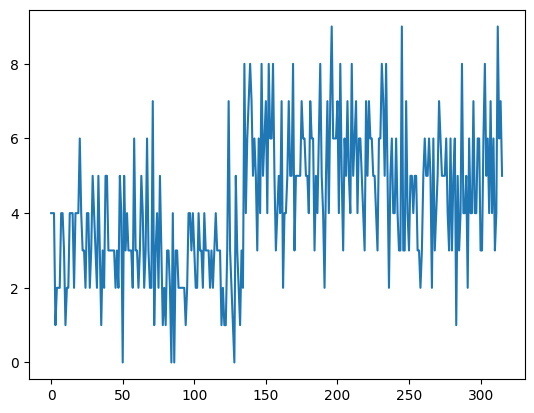

In [14]:
liste_Erreur_10ech_percent = []

nbrErreurTotal = 0

for i in range (0,4):
  if i == 0:
    ErrorGlioma = (liste_Erreur_Par_Classe[i]/nbrGliomaTumeur)*100
    print("Le pourcentage d'erreur pour une tumeur glioma est : " + str(ErrorGlioma) + "%")
    print("Le pourcentage de réussite pour une tumeur glioma est : " + str(100 - ErrorGlioma) + "% \n")
  elif i == 1:
    ErrorNoTumor = (liste_Erreur_Par_Classe[i]/nbrPasTumeur)*100
    print("Le pourcentage d'erreur pour une l'absence de tumeur est : " + str(ErrorNoTumor) + "%")
    print("Le pourcentage de réussite pour une l'absence de tumeur est : " + str(100 - ErrorNoTumor) + "% \n")
  elif i == 2:
    ErrorMenigioma = (liste_Erreur_Par_Classe[i]/nbrMeningiomaTumeur)*100
    print("Le pourcentage d'erreur pour une tumeur Menigioma est : " + str(ErrorMenigioma) + "%")
    print("Le pourcentage de réussite pour une tumeur Menigioma est : " + str(100 - ErrorMenigioma) + "% \n")
  elif i == 3:
    ErrorPituitary = (liste_Erreur_Par_Classe[i]/nbrPituitaryTumeur)*100
    print("Le pourcentage d'erreur pour une tumeur Pituitary est : " + str(ErrorPituitary) + "%")
    print("Le pourcentage de réussite pour une tumeur Pituitary est : " + str(100 - ErrorPituitary) + "% \n")

nbrTotalImages = nbrGliomaTumeur + nbrMeningiomaTumeur + nbrPasTumeur + nbrPituitaryTumeur

ErrorMedium = (ErrorGlioma + ErrorNoTumor + ErrorMenigioma + ErrorPituitary)/4
print("The medium error rate is : " + str(ErrorMedium) + "% \n"
      "The medium success rate is : " + str(100 - ErrorMedium) + "% \n"
     )

#SCHEMA DES ERREURS
plt.plot(liste_Erreur_10ech)
#AFFICHAGE DES SCHEMAS/FIGURES
plt.show()
